In [1]:
import os
import random
import itertools
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

from transformers import TFAutoModel, AutoTokenizer, BertConfig, TFBertModel

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [3]:
### READ DATA ###

df = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v2.json', lines=True)
df = df[df.category.isin(df.category.value_counts().tail(8).index)].copy() # select 8 low dimensional categories
map_label = dict(enumerate(df.category.factorize()[1]))
df['category'] = df.category.factorize()[0]

print(df.shape)
df.head()

(9768, 6)


,category,headline,authors,link,short_description,date
258,0,Attorney Aaron Schlossberg Insists Anti-Spanis...,David Moye,https://www.huffingtonpost.com/entry/aaron-sch...,"In the apology, Aaron Schlossberg claims he mo...",2018-05-22
351,0,Protesters Throw A Fiesta To Razz Lawyer Who R...,Mary Papenfuss,https://www.huffingtonpost.com/entry/fiesta-pr...,"Aaron Schlossberg was treated to outrage, mari...",2018-05-19
443,1,The Controversial Way Some California Schools ...,"EdSource, Editorial Partner",https://www.huffingtonpost.com/entry/restorati...,By David Washburn The two 9th-grade girls hear...,2018-05-17
456,0,Latino Man Insulted When Starbucks Barista Wri...,David Moye,https://www.huffingtonpost.com/entry/starbucks...,The coffee giant tried to apologize with a $50...,2018-05-17
543,0,Angry White Dude's Rant About People Speaking ...,David Moye,https://www.huffingtonpost.com/entry/edward-su...,The man tells an employee “Your staff is speak...,2018-05-16


In [4]:
### UTILITY FUNCTIONS FOR TOKENIZATIONS, MASKS AND SEGMENTS CREATION ###
### from: https://www.kaggle.com/akensert/bert-base-tf2-0-now-huggingface-transformer

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def convert_to_transformer_inputs(str1, str2, tokenizer, max_sequence_length, double=True):
    
    def return_id(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,
            add_special_tokens=True,
            max_length=length,
            truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_masks = [1] * len(input_ids)
        input_segments = inputs["token_type_ids"]
        
        padding_length = length - len(input_ids)
        padding_id = tokenizer.pad_token_id
        
        input_ids = input_ids + ([padding_id] * padding_length)
        input_masks = input_masks + ([0] * padding_length)
        input_segments = input_segments + ([0] * padding_length)
        
        return [input_ids, input_masks, input_segments]
    
    if double:
    
        input_ids_1, input_masks_1, input_segments_1 = return_id(
            str1, None, 'longest_first', max_sequence_length)

        input_ids_2, input_masks_2, input_segments_2 = return_id(
            str2, None, 'longest_first', max_sequence_length)

        return [input_ids_1, input_masks_1, input_segments_1,
                input_ids_2, input_masks_2, input_segments_2]
    
    else:
        
        input_ids, input_masks, input_segments = return_id(
            str1, str2, 'longest_first', max_sequence_length)

        return [input_ids, input_masks, input_segments,
                None, None, None]        

def compute_input_arrays(df, columns, tokenizer, max_sequence_length, double=True):
    
    input_ids_1, input_masks_1, input_segments_1 = [], [], []
    input_ids_2, input_masks_2, input_segments_2 = [], [], []
    for _, instance in tqdm(df[columns].iterrows(), total=len(df)):
        str1, str2 = instance[columns[0]], instance[columns[1]]

        ids_1, masks_1, segments_1, ids_2, masks_2, segments_2 = \
        convert_to_transformer_inputs(str1, str2, tokenizer, max_sequence_length, double=double)
        
        input_ids_1.append(ids_1)
        input_masks_1.append(masks_1)
        input_segments_1.append(segments_1)

        input_ids_2.append(ids_2)
        input_masks_2.append(masks_2)
        input_segments_2.append(segments_2)
        
    if double:
        
        return [np.asarray(input_ids_1, dtype=np.int32), 
                np.asarray(input_masks_1, dtype=np.int32), 
                np.asarray(input_segments_1, dtype=np.int32),
                np.asarray(input_ids_2, dtype=np.int32), 
                np.asarray(input_masks_2, dtype=np.int32), 
                np.asarray(input_segments_2, dtype=np.int32)]
    
    else:
        
        return [np.asarray(input_ids_1, dtype=np.int32), 
                np.asarray(input_masks_1, dtype=np.int32), 
                np.asarray(input_segments_1, dtype=np.int32)]

In [5]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df[['headline','short_description']], df['category'].values, 
                                                    random_state=33, test_size = 0.3)
del df

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6837, 2) (2931, 2)
(6837,) (2931,)


In [6]:
### IMPORT TOKENIZER ###

MAX_SEQUENCE_LENGTH = 300

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# **SIMPLE BERT (ONE INPUT)**

In [7]:
### CREATE SEQUENCES (id, mask, segments) FOR TRAIN AND TEST ###

input_train = compute_input_arrays(X_train, ['headline','short_description'], tokenizer, MAX_SEQUENCE_LENGTH, double=False)
input_test = compute_input_arrays(X_test, ['headline','short_description'], tokenizer, MAX_SEQUENCE_LENGTH, double=False)

In [8]:
def simple_bert():
    
    set_seed(33)
    
    opt = Adam(learning_rate=2e-5)
    
    id_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    mask_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    atn_ = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig()
    config.output_hidden_states = False # Set to True to obtain hidden states
    bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)
    
    embedding = bert_model(id_, attention_mask=mask_, token_type_ids=atn_)[0]
    
    x = GlobalAveragePooling1D()(embedding)    
    x = Dropout(0.2)(x)
    out = Dense(len(map_label), activation='softmax')(x)

    model = Model(inputs=[id_, mask_, atn_], outputs=out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)
    
    return model

In [9]:
model = simple_bert()
model.fit(input_train, y_train, epochs=3, batch_size=6)


Train on 6837 samples
Epoch 1/3
6837/6837 [==============================] - 311s 45ms/sample - loss: 0.7071
Epoch 2/3
6837/6837 [==============================] - 295s 43ms/sample - loss: 0.2715
Epoch 3/3
6837/6837 [==============================] - 295s 43ms/sample - loss: 0.1072


In [10]:
### PREDICT TEST ###

pred_test = np.argmax(model.predict(input_test), axis=1)

In [11]:
print(classification_report([map_label[i] for i in y_test], [map_label[i] for i in pred_test]))

                precision    recall  f1-score   support

ARTS & CULTURE       0.89      0.82      0.86       429
       COLLEGE       0.71      0.85      0.78       332
CULTURE & ARTS       0.89      0.84      0.87       286
     EDUCATION       0.83      0.63      0.72       277
   ENVIRONMENT       0.82      0.96      0.89       399
         FIFTY       0.82      0.86      0.84       416
     GOOD NEWS       0.80      0.77      0.78       450
 LATINO VOICES       0.91      0.85      0.88       342

      accuracy                           0.83      2931
     macro avg       0.83      0.82      0.83      2931
  weighted avg       0.83      0.83      0.83      2931



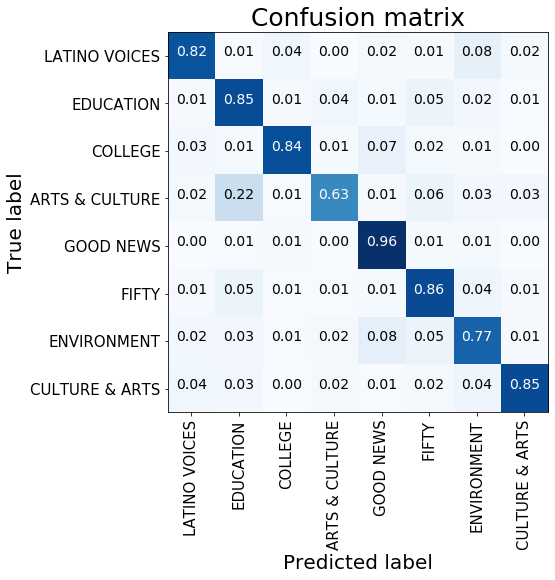

In [12]:
cnf_matrix = confusion_matrix([map_label[i] for i in y_test], 
                              [map_label[i] for i in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(map_label.values()))
plt.show()

# **DUAL BERT (TWO INPUT)**

In [13]:
### CREATE SEQUENCES (id, mask, segments) FOR TRAIN AND TEST ###

input_train = compute_input_arrays(X_train, ['headline','short_description'], tokenizer, MAX_SEQUENCE_LENGTH)
input_test = compute_input_arrays(X_test, ['headline','short_description'], tokenizer, MAX_SEQUENCE_LENGTH)

In [14]:
def dual_bert():
    
    set_seed(33)
    
    opt = Adam(learning_rate=2e-5)
    
    id1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    id2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    mask1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    mask2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    atn1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    atn2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig() 
    config.output_hidden_states = False # Set to True to obtain hidden states
    bert_model1 = TFBertModel.from_pretrained('bert-base-uncased', config=config)
    bert_model2 = TFBertModel.from_pretrained('bert-base-uncased', config=config)
    
    embedding1 = bert_model1(id1, attention_mask=mask1, token_type_ids=atn1)[0]
    embedding2 = bert_model2(id2, attention_mask=mask2, token_type_ids=atn2)[0]
    
    x1 = GlobalAveragePooling1D()(embedding1)
    x2 = GlobalAveragePooling1D()(embedding2)
    
    x = Concatenate()([x1, x2])
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(len(map_label), activation='softmax')(x)

    model = Model(inputs=[id1, mask1, atn1, id2, mask2, atn2], outputs=out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)
    
    return model

In [15]:
model = dual_bert()
model.fit(input_train, y_train, epochs=3, batch_size=6)

Train on 6837 samples
Epoch 1/3
6837/6837 [==============================] - 593s 87ms/sample - loss: 0.7904
Epoch 2/3
6837/6837 [==============================] - 560s 82ms/sample - loss: 0.3198
Epoch 3/3
6837/6837 [==============================] - 560s 82ms/sample - loss: 0.1341


In [16]:
### PREDICT TEST ###

pred_test = np.argmax(model.predict(input_test), axis=1)

In [17]:
print(classification_report([map_label[i] for i in y_test], [map_label[i] for i in pred_test]))

                precision    recall  f1-score   support

ARTS & CULTURE       0.80      0.90      0.85       429
       COLLEGE       0.73      0.83      0.77       332
CULTURE & ARTS       0.91      0.84      0.87       286
     EDUCATION       0.83      0.64      0.72       277
   ENVIRONMENT       0.86      0.96      0.91       399
         FIFTY       0.83      0.86      0.84       416
     GOOD NEWS       0.84      0.73      0.78       450
 LATINO VOICES       0.88      0.85      0.86       342

      accuracy                           0.83      2931
     macro avg       0.83      0.82      0.83      2931
  weighted avg       0.83      0.83      0.83      2931



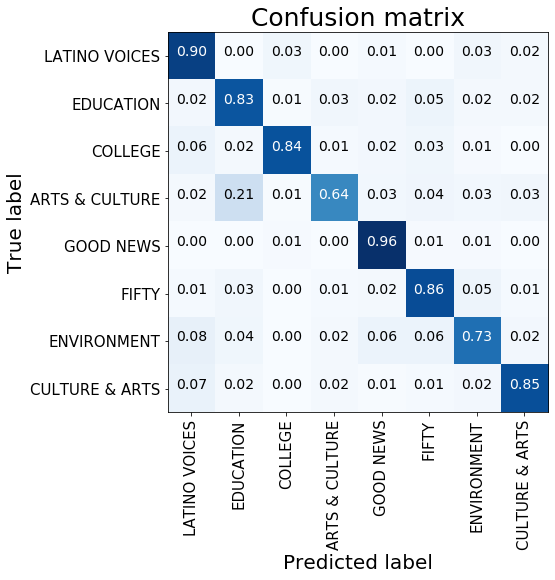

In [18]:
cnf_matrix = confusion_matrix([map_label[i] for i in y_test], 
                              [map_label[i] for i in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(map_label.values()))
plt.show()

# **SIAMESE BERT (TWO INPUT)**

In [19]:
def siamese_bert():
    
    set_seed(33)
    
    opt = Adam(learning_rate=2e-5)
    
    id1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    id2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    mask1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    mask2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    atn1 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    atn2 = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig()
    config.output_hidden_states = False # Set to True to obtain hidden states
    bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)
    
    embedding1 = bert_model(id1, attention_mask=mask1, token_type_ids=atn1)[0]
    embedding2 = bert_model(id2, attention_mask=mask2, token_type_ids=atn2)[0]
    
    x1 = GlobalAveragePooling1D()(embedding1)
    x2 = GlobalAveragePooling1D()(embedding2)
    
    x = Concatenate()([x1, x2])
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(len(map_label), activation='softmax')(x)

    model = Model(inputs=[id1, mask1, atn1, id2, mask2, atn2], outputs=out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)
    
    return model

In [20]:
model = siamese_bert()
model.fit(input_train, y_train, epochs=3, batch_size=6)

Train on 6837 samples
Epoch 1/3
6837/6837 [==============================] - 578s 84ms/sample - loss: 0.8184
Epoch 2/3
6837/6837 [==============================] - 547s 80ms/sample - loss: 0.3680
Epoch 3/3
6837/6837 [==============================] - 547s 80ms/sample - loss: 0.1916


In [21]:
### PREDICT TEST ###

pred_test = np.argmax(model.predict(input_test), axis=1)

In [22]:
print(classification_report([map_label[i] for i in y_test], [map_label[i] for i in pred_test]))

                precision    recall  f1-score   support

ARTS & CULTURE       0.79      0.89      0.84       429
       COLLEGE       0.77      0.82      0.79       332
CULTURE & ARTS       0.91      0.76      0.83       286
     EDUCATION       0.75      0.73      0.74       277
   ENVIRONMENT       0.85      0.96      0.90       399
         FIFTY       0.80      0.88      0.84       416
     GOOD NEWS       0.86      0.72      0.78       450
 LATINO VOICES       0.92      0.85      0.88       342

      accuracy                           0.83      2931
     macro avg       0.83      0.82      0.82      2931
  weighted avg       0.83      0.83      0.83      2931



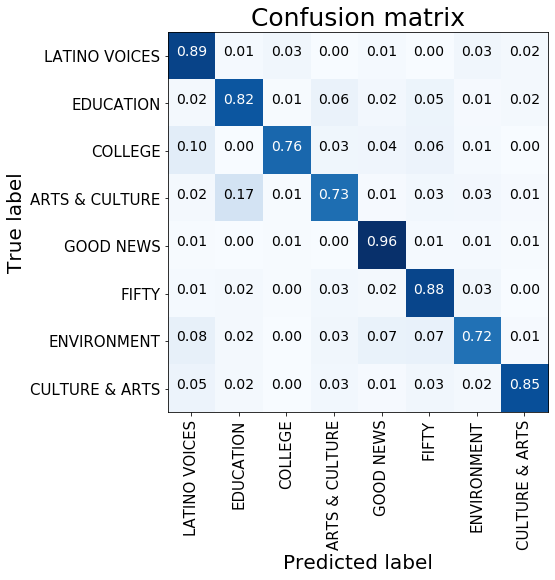

In [23]:
cnf_matrix = confusion_matrix([map_label[i] for i in y_test], 
                              [map_label[i] for i in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(map_label.values()))
plt.show()